# Optimizacion de parametros

In [1]:
%pylab inline
import time
import numpy as np
import matplotlib.pyplot as plt
from utils import img_utils
import seaborn as sns
import utils.math_utils as mat_utils
#import nibabel as nib
#from dipy.core.gradients import gradient_table
import cvxpy as cvx
reload(img_utils)
import load.hcp_img_loader as hcp
from utils.persistance.persistence_array import parray


Populating the interactive namespace from numpy and matplotlib


In [2]:
import mapmri.mapmri as mp
import mymapl.minmapl as mapl
import load.samples as samples

def mm(A, cast_int=True):
    if cast_int:
        return (int(A.min()), int(A.max()))
    else:
        return (A.min(), A.max())


## MapMri

In [3]:
import mymapl.minmapl as mapl


# 3D Tv-Norm

$ \sum_{ijk \in positions(I)} \left|\left| (I_{i,j,k}, I_{i,j,k}, I_{i,j,k}) - ( I_{i-1,j,k}, I_{i,j-1,k},  I_{i,j,k-1}) \right|\right| $

In [4]:
import optimization.tvnorm3d as tvn

## Problem definition

$ \min_{C^{hr}} \{ ||GC^{hr} - C^{lr}||^2  + ||C||_{1} \}$


In [5]:
def define_problem_f1(c_lr, vhr, vlr, G, M, U, tau, gtab, scale, intercept=None):
    Nx, Ny, Nz = (12, 12, 12)#TODO: pasar
    Nb, Nc = M.shape
    
    ## LR volumes
    Clr = c_lr
    
    ## MAPL params
    #cvxChr = cvx.Constant(C_hr.reshape(-1, order='F'))
    
    cvxChr = cvx.Variable(vhr*Nc, name='cvxChr')
    ChrValueInitial = np.ones((vhr*Nc, 1), dtype='float32')
    for c in xrange(Nc): 
        c_offset_hr = c*vhr
        ChrValueInitial[c_offset_hr:c_offset_hr+vhr] = ChrValueInitial[c_offset_hr:c_offset_hr+vhr]*Clr[c].mean()
    cvxChr.value = ChrValueInitial
    
    ## Fidelity expression
    cvxG = G
    fidelity_list = []
    lapace_list = []
    for c in xrange(Nc):
        c_offset_hr = c*vhr
        Chr_c = cvxChr[c_offset_hr:c_offset_hr+vhr]
        # Aprovecho para setearle un valor unicia
        Gc = cvx.Constant(G[c])
        Clr_c = cvx.Constant(Clr[c])
        #Clr_c = cvx.Variable(Clr[c].shape[0], Clr[c].shape[1], name='Clr_'+str(c))

        #       Gc:(216:vlr, 1728:vhr) Chr_c:(1728:vhr, 1) Clr_c:(1, 216:vlr)
        if intercept is not None:
            cvxInt_c = cvx.Constant(intercept[c])
            #cvxInt_c:(vlr, 1)
            fid_b = cvx.sum_squares((Gc*Chr_c+cvxInt_c) - Clr_c.T)
        else:
            fid_b = cvx.sum_squares(Gc*Chr_c - Clr_c.T)
        
        fidelity_list.append(fid_b)    
    #cvxNc = cvx.Constant(Nc)
    #cvxFidelityExp = cvx.inv_pos(cvxNc)*sum(fidelity_list)
    cvxFidelityExp = sum(fidelity_list)
    
    ## Laplacian regularization
    cvxU = cvx.Constant(U)
    regLaplade_list = []
    vhrc = vhr*Nc
    for voxel in xrange(vhr):
        cvxLapaceReg = cvx.quad_form(cvxChr[voxel:vhrc:vhr], cvxU)
        regLaplade_list.append(cvxLapaceReg**2)
    cvxLaplaceRegExp = sum(regLaplade_list)
    
    
    ## 3D Tv-Norm Regularization
    cvxC_byCoef = cvx.reshape(cvxChr, vhr, Nc)
    # (Nb,Nc)*(Nc,vhr) = (Nb, vhr).T = (vhr, Nb) 
    cvxYhr = cvx.reshape((M*cvxC_byCoef.T).T, vhr*Nb, 1)
    #vx3DTvNomExp = tvn.tv3d(cvxYhr, Nx, Ny, Nz, Nb)
    
    
    #Sparcity regularization
    cvxNorm1 = cvx.norm1(cvxChr)
    
    
    ## Mapl weight
    beta = cvx.Parameter(value=3*1.452e-15, name='beta', sign='positive')#3.197e-10
    ## Sparcity weight
    alpha = cvx.Parameter(value=1.627e-15, name='alpha', sign='positive')#4.865e-10
    ## Fidelity weight
    #gamma = cvx.Parameter(value=0.05, name='gamma',sign='positive')
    lamda = cvx.Parameter(value=1., name='lamda',sign='positive')
    ### AS VARIABLES
    # beta = cvx.Variable(name='beta')
    # beta.value = 0.2
    ## Sparcity weight
    # alpha = cvx.Variable(name='alpha')
    # alpha.value = 4000
    ## Fidelity weight
    # gamma = cvx.Variable(name='gamma')
    # lamda = cvx.Variable(name='lamda')
    # lamda.value =0.5
    
    # Form objective.
    #obj = cvx.Minimize(cvxFidelityExp + betha*cvxLapaceRegExp + alpha*cvx.norm(cvxChr) + gamma*cvx3DTvNomExp)
    obj = cvx.Minimize(lamda*cvxFidelityExp + beta*cvxLaplaceRegExp + alpha*cvxNorm1)
         
    # Constraints
    #constraints = [lamda > 0 , alpha > 0, beta > 0]
    constraints = [cvxYhr >= 0]
    #Agregar q M*C es positivo o deberia

    # Form and solve problem.
    prob = cvx.Problem(obj, constraints)
    
    return prob, cvxFidelityExp ,  cvxLaplaceRegExp , cvxNorm1


In [6]:
"""
def solveMin(c_lr, i_hr_shape, G, M, U, tau, gtab, intercept=None, scale=2, max_iters=1500, verbose=False, prob=None):
    Nx, Ny, Nz, Nb = i_hr_shape
    Nb, Nc = M.shape
    nx, ny, nz = Nx/scale, Ny/scale, Nz/scale 
    vhr, vlr = Nx*Ny*Nz, nx*ny*nz 
    
    cvxFidelityExp ,  cvxLaplaceRegExp , cvxNorm1 = None, None, None
    if prob is None :
        prob, cvxFidelityExp ,  cvxLaplaceRegExp , cvxNorm1 = define_problem_with_mapl(
                                    c_lr, 
                                    vhr, 
                                    vlr,
                                    G, 
                                    M, U,tau,
                                    gtab,
                                    scale,
                                    intercept=intercept)
    
    
    
    start_time = time.time()
    res = prob.solve(solver='SCS', max_iters=max_iters, eps=1.0e-05, verbose=verbose )  # Returns the optimal value.
    #res = prob.solve(solver='ECOS')  # Returns the optimal value.
    
    seg = time.time() - start_time

    minutes = int(seg / 60)
    print("--- time of optimization : %d' %d'' ---" % (minutes , seg%60))
    print "--- status:", prob.status, "optimal value", prob.value
    print 

    variables = dict( (v.name(), v) for v in prob.variables())
    #parameters = dict( (v.name(), v) for v in prob.parameters())
    #print 'alpha=', variables['alpha'].value ,'beta=',  variables['beta'].value
    print variables
    #A, C = i_hr, C_hr
    
    cvxChr = variables['cvxChr']
    # cvxChr: (vhrc, 1) M:(Nb,Nc)
    
    C = np.asarray(cvxChr.value, dtype='float32').reshape((Nx, Ny, Nz, Nc), order='F')

    A = M.dot(C.reshape((Nx*Ny*Nz, Nc), order='F').T).T
    A = A.reshape((Nx, Ny, Nz, Nb), order='F')
    
    print 'cvxFidelityExp', cvxFidelityExp.value   
    print 'cvxLaplaceRegExp', cvxLaplaceRegExp.value
    print 'cvxNorm1', cvxNorm1.value 
    
    return A, C, seg, prob, cvxFidelityExp, cvxLaplaceRegExp , cvxNorm1
"""
print 

In [7]:
def solveMin_fitCosnt(name_parameter, the_range, c_lr, i_hr, G, M, U, tau, gtab, intercept=None, scale=2, 
                      max_iters=1500, verbose=False, prob=None):
    Nx, Ny, Nz, Nb = i_hr.shape
    Nb, Nc = M.shape
    nx, ny, nz = Nx/scale, Ny/scale, Nz/scale 
    vhr, vlr = Nx*Ny*Nz, nx*ny*nz 
    
    cvxFidelityExp,  cvxLaplaceRegExp, cvxNorm1 = None, None, None
        
    b1000_index = indexs(gtab.bvals, 1000)
    b2000_index = indexs(gtab.bvals, 2000)
    b3000_index = indexs(gtab.bvals, 3000)
    
    base_folder = RES_BASE_FOLDER  + name_parameter + '/'
    measures = ['mse', 'mse1000', 'mse2000', 'mse3000']
    info = dict((key, parray( base_folder + key + '_'+subject+'.txt')) for key in measures)
    
    #info = {'mse':parray(RES_BASE_FOLDER+'mse_'+the), 'mse1000':[],'mse2000':[],'mse3000':[]}
    for val in the_range :
        prob, cvxFidelityExp ,  cvxLaplaceRegExp , cvxNorm1 = define_problem_f1(
                                    c_lr, 
                                    vhr, 
                                    vlr,
                                    G, 
                                    M, U,tau,
                                    gtab,
                                    scale,
                                    intercept=intercept)

        parameters = dict( (v.name(), v) for v in prob.parameters())
        parameters[name_parameter].value = val
    
        start_time = time.time()
        res = prob.solve(solver='SCS', max_iters=max_iters, eps=1.0e-05, verbose=verbose )  # Returns the optimal value.
        #res = prob.solve(solver='ECOS')  # Returns the optimal value.

        seg = time.time() - start_time

        minutes = int(seg / 60)
        print("--- time of optimization : %d' %d'' ---" % (minutes , seg%60))
        print "--- status:", prob.status, "optimal value", prob.value
        print 

        variables = dict( (v.name(), v) for v in prob.variables())
        #parameters = dict( (v.name(), v) for v in prob.parameters())
        #print 'alpha=', variables['alpha'].value ,'beta=',  variables['beta'].value
        print variables
        #A, C = i_hr, C_hr

        cvxChr = variables['cvxChr']
        # cvxChr: (vhrc, 1) M:(Nb,Nc)

        C = np.asarray(cvxChr.value, dtype='float32').reshape((Nx, Ny, Nz, Nc), order='F')

        A = M.dot(C.reshape((Nx*Ny*Nz, Nc), order='F').T).T
        A = A.reshape((Nx, Ny, Nz, Nb), order='F')

        mse = ((A-i_hr)**2).mean()
        info['mse'].append(mse)
        
        mse = ((A[:, :, :, b1000_index]-i_hr[:, :, :, b1000_index])**2).mean()
        info['mse1000'].append(mse)
        
        mse = ((A[:, :, :, b2000_index]-i_hr[:, :, :, b2000_index])**2).mean()
        info['mse2000'].append(mse)
        
        mse = ((A[:, :, :, b3000_index]-i_hr[:, :, :, b3000_index])**2).mean()
        info['mse3000'].append(mse)
        
        if cvxFidelityExp is not None:
            print 'cvxFidelityExp', cvxFidelityExp.value
        if cvxLaplaceRegExp is not None:
            print 'cvxLaplaceRegExp', cvxLaplaceRegExp.value
        if cvxNorm1 is not None:
            print 'cvxNorm1', cvxNorm1.value 

    return A, C, seg, prob, cvxFidelityExp, cvxLaplaceRegExp , cvxNorm1, info

def indexs(a, val):
    return [ i for i in xrange(a.size) if a[i] == val]

In [12]:
def params_for(the_one_out, sample_maker, n_samples, loader_func, scale=2):
    ## The one that left out to validate
    #i_hr, i_lr, gtab = samples.get_sample_of_dwi(the_one_out, subjects, loader_func, scale=scale)
    i_hr, i_lr, gtab = samples.get_sample_of_dwi(subjects[the_one_out], 0,0,0, loader_func, scale=scale)
    
    #C_hr, _, _ = samples.get_sample_of_mapl(the_one_out, subjects, loader_func, scale=scale)
    
    ### Aca shiftear el arreglo de sujetos (train deja el ultimo afuera del entrenamiento)
    
    #lr_samples, hr_samples = samples.buildT_grouping_by(sample_maker, n_samples) #lr, hr
    print subjects
    lr_samples, hr_samples = samples.buildT_grouping_by(subjects, 0, 0, 0, sample_maker, scale=scale) #lr, hr

    
    # Build downsampling matrix
    print '= Training and fiting ...'
    regr, chr_train , clr_train, intercept = \
                e1f.train_grouping_by(hr_samples, lr_samples, intercept=False)
    
    chr_test, clr_test = {}, {}
    for c in chr_train.keys():
        """ 
        dmri_X_train = X.T[:-1]
        dmri_X_test = X.T[-1:]
        """
        chr_test[c] = chr_train[c][-1:, :]
        chr_train[c] = chr_train[c][:-1, :]
        clr_test[c] = clr_train[c][-1:, :]
        clr_train[c] = clr_train[c][:-1, :]
    
    del(chr_train)
    del(clr_train)
    del(chr_test)
    print 'clr_test[0].shape', clr_test[0].shape
    
    G = dict((c,csr_matrix(regr[c].coef_)) for c in regr.keys())
    
    # Mapl params
    M, tau, mu, U = mapl.get_mapl_params2(gtab, radial_order = 4)
    print 'U.shape', U.shape
    
    return i_hr, i_lr, gtab, G,intercept, M, tau, mu, U , clr_test
    

## Solving the problem and cross-validation (leave one out)

== Leaving out: # 100307
.Apunto de cargar bvals 100307
.Apunto de cargar bvecs 100307
Apunto de cargar patch  100307
LOADING ./HCP/100307/data_medium40g_12x12x12x40_100307.nii.gz
scale= 2 lr.shape= (6, 6, 6, 40)
[100408, 180129, 180432, 180836, 180937, 100307]
.Apunto de cargar bvals 100408
.Apunto de cargar bvecs 100408
Apunto de cargar patch  100408
LOADING ./HCP/100408/data_medium40g_12x12x12x40_100408.nii.gz
scale= 2 lr.shape= (6, 6, 6, 40)
.Apunto de cargar bvals 100408
.Apunto de cargar bvecs 100408
Apunto de cargar patch  100408
LOADING ./HCP/100408/data_medium40g_12x12x12x40_100408.nii.gz
scale= 2 lr.shape= (6, 6, 6, 40)
.Apunto de cargar bvals 100408
.Apunto de cargar bvecs 100408
Apunto de cargar patch  100408
LOADING ./HCP/100408/data_medium40g_12x12x12x40_100408.nii.gz
scale= 2 lr.shape= (6, 6, 6, 40)
.Apunto de cargar bvals 100408
.Apunto de cargar bvecs 100408
Apunto de cargar patch  100408
LOADING ./HCP/100408/data_medium40g_12x12x12x40_100408.nii.gz
scale= 2 lr.shape= 

<Container object of 3 artists>

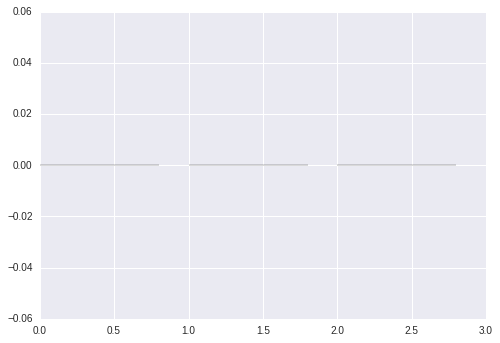

In [14]:
from scipy.sparse import csr_matrix
import experimento1_funciones as e1f
reload(e1f)

RES_BASE_FOLDER = './results/exp6b/'
VMIN, VMAX=0, 1

voi_hr_shape = (12, 12, 12, 6)
voi_lr_shape = (6, 6, 6, 6)
subjects = [100307, 100408, 180129, 180432, 180836, 180937]
#subjects = [100307, 100408, 180129, 180432]

bvals2000pos = [18, 27, 69, 75, 101, 107]

# Esto es por si quiero alguna S0
#img_s0, gtab_s0 = load_subject_small(0, subjects, bval=5, bvalpos=bvals5pos[0:6])
#i_hr=img.get_data()
#S0 = img_s0.get_data()

reload(hcp)

#print '#Qvals: ', gtab.bvals.shape
#print 'Bvals: ', set(gtab.bvals)
## Con imagenes pequenas multi-shel
loader_func = hcp.load_subject_medium_noS0
sample_maker = samples.get_sample_maker_of_map(loader_func)

n_samples = 6
iterations = 1

# Metrics to save
mins_lamda = parray(RES_BASE_FOLDER+'/lamda/mins_mses.txt')

## For save results
# base_folder = RES_BASE_FOLDER
## For NOT save results
base_folder = RES_BASE_FOLDER

times = parray(RES_BASE_FOLDER+'/times.txt')
optimal_vals = parray(RES_BASE_FOLDER+'/optimal_vals.txt')

for i in range(0, iterations):
    subjects.append(subjects.pop(0))
    subject = str(subjects[len(subjects)-1])
    print '== Leaving out: #', subject
    the_one_out = len(subjects)-1
    
    i_hr, i_lr, gtab, G, intercept, M, tau, mu, U , clr_test = \
        params_for(the_one_out, sample_maker, n_samples, loader_func, scale=2)

    print 'i_hr.shape', i_hr.shape, 'lr.shape', i_lr.shape
    
    print '= Solving optimization problem ...'    
    name_parameter = 'lamda'
    rango = np.arange(0, 0.4, 0.1)
    #rango = [1]
    A, C, seg, prob, cvxFidelityExp, cvxLaplaceRegExp, cvxNorm1, res = \
        solveMin_fitCosnt(name_parameter,
                          rango,  
                          clr_test, 
                          i_hr, 
                          G, 
                          M, U, tau, 
                          gtab, 
                          intercept=intercept, 
                          scale=2, 
                          max_iters=10, 
                          verbose=False)

    index = np.argmin(np.array(res['mse']))
    min_lamda = rango[index]
    mins_lamda.append(min_lamda)

    times.append(seg)
    optimal_vals.append(prob.value)

mins_lamda = mins_lamda.asnumpy()

# Log spended
total_sec = np.array(times).sum()
print ' === TOTAL TIME :',  str(int(total_sec//60))+"'", str(int(total_sec%60))+ '"'

# Persist results
#if base_folder is not None: 
#    np.save(base_folder+ 'mins_alphas', mins_lamda)

print 'mean=', mins_lamda.mean(), mins_lamda

plt.bar(xrange(mins_lamda.size), mins_lamda)


In [11]:
rango, mins_lamda

(array([ 0. ,  0.2,  0.4,  0.6,  0.8]), array([ 0.2,  0.6,  0.6]))

In [ ]:
# Para darle otra ronda
A, C, seg, prob, cvxFidelityExp ,  cvxLaplaceRegExp , cvxNorm1 = \
        solveMin(clr_test, i_hr.shape, G, M, U,  tau, gtab, prob=prob, max_iters=1500, verbose=True)
#parameters = dict((c.name(), c) for c in prob.parameters())
#betha, alpha = parameters['betha'],  parameters['alpha']

#H, _, S0hr, _,  gtab = get_sample_dwi(2, subjects, loader_func, scale=2)
#img_utils._ish(H, b=7, vmin=H.min(), vmax=H.max())

In [ ]:
dict((v.name(), v.value) for v in prob.variables())

In [ ]:

b=0
print A[:,6,:, b].mean(), np.std(A), i_hr[:,6,:, b].mean(), np.std(i_hr)

img_utils._ish(A, b=b, vmin=A.min(), vmax=A.max())
gtab.bvals[b]

(array([ 40.,  14.,  31.,  35.,  12.,   3.,   5.,   3.,   0.,   1.]),
 array([ 0.04373868,  0.19284255,  0.34194643,  0.4910503 ,  0.64015417,
         0.78925804,  0.93836191,  1.08746579,  1.23656966,  1.38567353,
         1.5347774 ]),
 <a list of 10 Patch objects>)

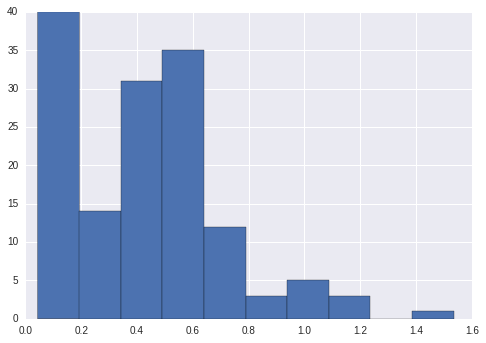

In [264]:
#hist(A[:,6,:, b].flatten(), range=(-0.03,0.15))
hist(i_hr[:,6,:, b].flatten())


recons (-1.1550033550036809e-05, 0.18312468080716857, 1.6459401190968876) (12, 12, 12, 37)
orig (0.0020386195, 0.29971552, 3.2994506) (12, 12, 12, 37)
con la primer forma de tvnorm
dif_norm_hrs [71.392983858290606]
Yhr_recons_norms [77.573542056357724]
Yhr_norms [99.343712]
times [46.43727993965149]
optimal_vals [21.795486502295198]


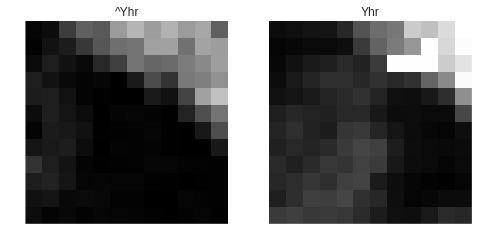

In [265]:
img_utils._isc(A, i_hr, b=4, vmin=0, vmax=1, titles=['^Yhr', 'Yhr'])



#img_utils._is(A, vmin=A.min(), vmax=A.max())
print 'recons', (A.min(), A.mean(), A.max()), A.shape
print 'orig',(i_hr.min(), i_hr.mean(), i_hr.max()), i_hr.shape
#G.shape

print 'con la primer forma de tvnorm'
print 'dif_norm_hrs', dif_norm_hrs
print 'Yhr_recons_norms', Yhr_recons_norms
print 'Yhr_norms', Yhr_norms
print 'times',times
print 'optimal_vals', optimal_vals

# HR Testing reconstruction 


mse= 0.0811677926161


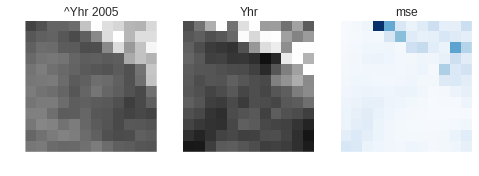

((0, 1), (0, 1), 'mse=', (0, 2))

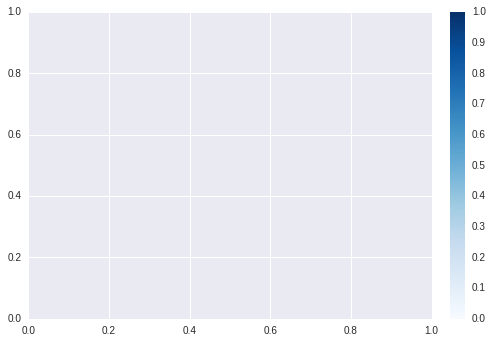

In [15]:
mse = ((A-i_hr)**2).mean(axis=3)
print 'mse=', ((A-i_hr)**2).mean()

bval = 5
titles = ['^Yhr '+str(int(gtab.bvals[bval])), 'Yhr', 'mse']
plt, _, _, im3 = img_utils._isc3(A, i_hr, mse,  b=bval,  vmin=[0, 0], vmax=[1, 1], titles=titles)
plt.colorbar(im3,fraction=0.056, pad=0.04)
mm(A[:,6,:, bval]), mm(i_hr[:,6,:, bval]), 'mse=', mm(mse)

mse= 0.0797196906937


((0, 0), (0, 1), 'mse=', (0, 1))

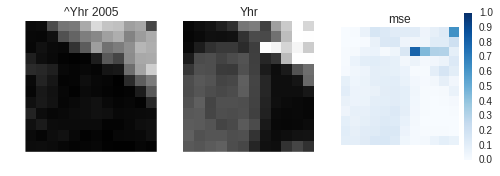

In [266]:
mse = ((A-i_hr)**2).mean(axis=3)
print 'mse=', ((A-i_hr)**2).mean()

bval = 5
titles = ['^Yhr '+str(int(gtab.bvals[bval])), 'Yhr', 'mse']
plt, _, _, im3 = img_utils._isc3(A, i_hr, mse,  b=bval,  vmin=[0, 0], vmax=[1, 1], titles=titles)
plt.colorbar(im3,fraction=0.056, pad=0.04)
mm(A[:,6,:, bval]), mm(i_hr[:,6,:, bval]), 'mse=', mm(mse)

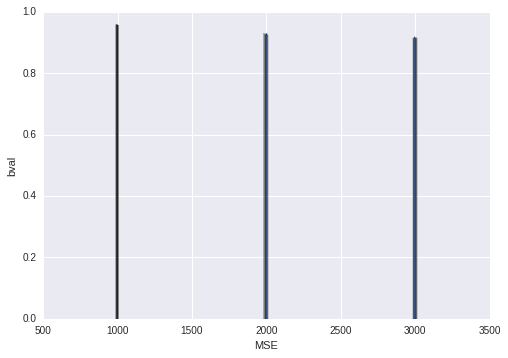

In [41]:
errel = errrel_layers(A, i_hr)
errs =[errel[:,:,:,b].mean() for b in xrange(A.shape[3])]

plt.bar(gtab.bvals, errs),errs[16], errs[32], gtab.bvals[b], #set(gtab.bvals
#plt.xlim(985, 1010)
plt.xlabel('MSE')
plt.ylabel('bval')


(<Container object of 37 artists>,
 2.0843988601706585,
 2.0108313472280379,
 995.0)

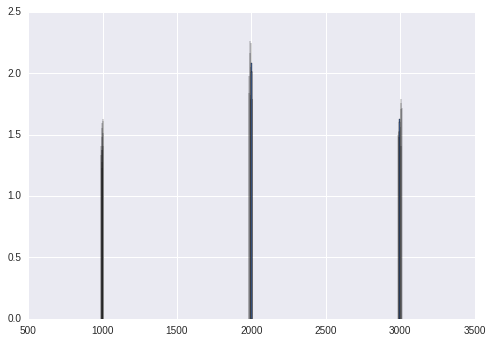

In [203]:
errel = errrel_layers(A, i_hr)
errs =[errel[:,:,:,b].mean() for b in xrange(A.shape[3])]



plt.bar(gtab.bvals, errs),errs[16], errs[32], gtab.bvals[b], #set(gtab.bvals)

In [40]:
def errrel_layers(A, B):
    err_rel = np.zeros(A.shape)
    for b in xrange(A.shape[3]):
        err_rel[:,:,:,b] = np.divide(np.abs(A[:,:,:,b]-B[:,:,:,b]), B[:,:,:,b]+0.01)
    return err_rel
    

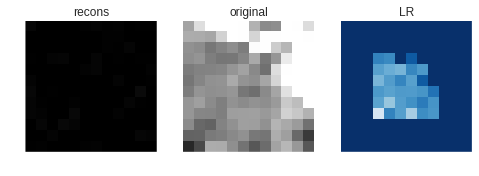

990.0

In [11]:
I_lr = np.ones(i_hr.shape)


for b in xrange(I_lr.shape[3]):
    I_lr[3:9,3:9,3:9,b] = i_lr[:, :, :, b]
b=6
plt, _, _, im3 = img_utils._isc3(A, i_hr, I_lr, b=b, vmin=0,vmax=0.8, titles=['recons', 'original', 'LR'])
plt.set_cmap('gray')
gtab.bvals[b]

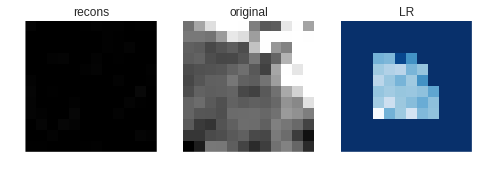

990.0

In [38]:
I_lr = np.ones(i_hr.shape)


for b in xrange(I_lr.shape[3]):
    I_lr[3:9,3:9,3:9,b] = i_lr[:, :, :, b]
b=6
plt, _, _, im3 = img_utils._isc3(A, i_hr, I_lr, b=b, vmax=1, titles=['recons', 'original', 'LR'])
plt.set_cmap('gray')
gtab.bvals[b]

990.0

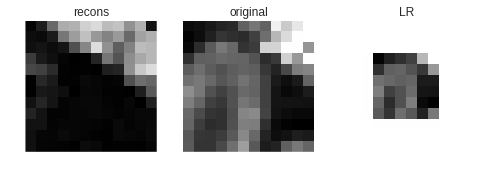

In [283]:
I_lr = np.ones(i_hr.shape)


for b in xrange(I_lr.shape[3]):
    I_lr[3:9,3:9,3:9,b] = i_lr[:, :, :, b]
b=6
plt, _, _, im3 = img_utils._isc3(A, i_hr, I_lr, b=b, vmax=1, titles=['recons', 'original', 'LR'])
plt.set_cmap('gray')
gtab.bvals[b]

# Testing Mapl reconstruction to clr

 (0, 0)
Error relativo max,min u std (0, 0) 0 0


<module 'matplotlib.pyplot' from '/user/lgomez/home/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

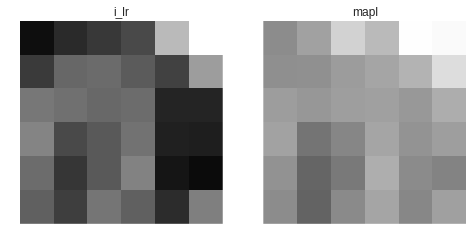

In [286]:
nx, ny, nz, Nb = i_lr.shape
Nb, Nc =  M.shape

_, C_lr, _ = get_sample(the_one_out, subjects, loader_func, scale=2)
B = M.dot(C_lr.reshape((nx*ny*nz, Nc), order='F').T).T
B = B.reshape((nx, ny, nz, Nb), order='F')
    

err = np.abs(B - i_lr)
err_rel = np.divide(err, i_lr+1)#para q no de infinito

print mm(err) 
print 'Error relativo max,min u std', mm(err_rel), int(err_rel.mean()), \
                                      int(np.std(err_rel)) 

#img_utils._isc(i_hr, Eq_reconst,b=b, vmin=0, vmax=i_hr.max(), titles=['i_hr', 'cvxpy'])
img_utils._isc(i_lr, B,b=b, vmin=0, vmax=1, titles=['i_lr', 'mapl'])


(0, 2)
Error relativo max,min u std (0, 1) 0 0


<module 'matplotlib.pyplot' from '/user/lgomez/home/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

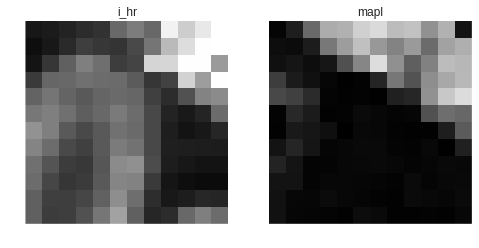

In [289]:
Nx, Ny, Nz, Nb = i_hr.shape
Nb, Nc =  M.shape

C_hr, _, _ = get_sample(the_one_out, subjects, loader_func, scale=2)
A_mapl = M.dot(C_hr.reshape((Nx*Ny*Nz, Nc), order='F').T).T
A_mapl = A.reshape((Nx, Ny, Nz, Nb), order='F')
    

err = np.abs(A_mapl - i_hr)
err_rel = np.divide(err, i_hr+1)#para q no de infinito

print mm(err) 
print 'Error relativo max,min u std', mm(err_rel), int(err_rel.mean()), \
                                      int(np.std(err_rel)) 

#img_utils._isc(i_hr, Eq_reconst,b=b, vmin=0, vmax=i_hr.max(), titles=['i_hr', 'cvxpy'])
img_utils._isc(i_hr, A_mapl,b=b, vmin=0, vmax=1, titles=['i_hr', 'mapl'])
